In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.preprocessing import label_binarize

> 1. multiple class fit into one model

In [55]:
logreg_multi = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')

iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
Y = iris.target

In [56]:
logreg_multi.fit(X, Y)
y_pred_multi = logreg_multi.predict(X)
y_pred_prob_multi = logreg_multi.predict_proba(X)

df_t = pd.DataFrame(list(zip(Y, y_pred_multi,y_pred_prob_multi)),
              columns=['Y','Y_pred', 'Y_pred_prob'])
df_t.tail(3)

,Y,Y_pred,Y_pred_prob
147,2,2,"[5.253300047277107e-31, 0.369730486108615, 0.6..."
148,2,2,"[7.438851019294047e-16, 0.4689005014309357, 0...."
149,2,1,"[9.222681495563846e-17, 0.6474876683743234, 0...."


In [58]:
from sklearn.metrics import classification_report
print(classification_report(Y, y_pred_multi))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.75      0.76      0.75        50
           2       0.76      0.74      0.75        50

   micro avg       0.83      0.83      0.83       150
   macro avg       0.83      0.83      0.83       150
weighted avg       0.83      0.83      0.83       150



In [60]:
"""
binary labels so we can do roc_auc_score with an average
"""

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

multiclass_roc_auc_score(Y, y_pred_multi, average="macro")
# multiclass_roc_auc_score(Y, y_pred_prob_ovr, average="macro") this will throw an error

0.875

> ROC curve for multiple class by using OneVsRest
  - multiple class ROC curve
     - https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)
y_pred = classifier.predict(X_test)
y_pred_prob = classifier.predict_proba(X_test)

In [70]:
y_score[:3]

array([[-0.76301132, -0.36482547,  0.12386354],
       [-0.20224493, -0.63144366, -0.16612302],
       [ 0.11801481, -0.80263073, -0.32055874]])

In [75]:
print(y_pred[:3])
print(y_pred_prob[:3])
print(y_test[:3])

[[0 0 1]
 [0 0 0]
 [1 0 0]]
[[0.08684464 0.25925151 0.77480969]
 [0.39281275 0.27972587 0.48662116]
 [0.65800574 0.29338079 0.32298958]]
[[0 0 1]
 [0 1 0]
 [1 0 0]]


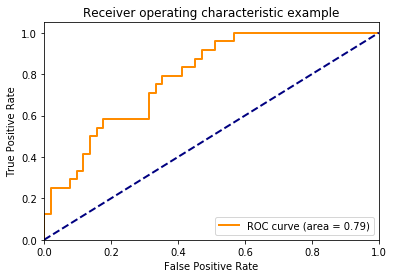

In [76]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

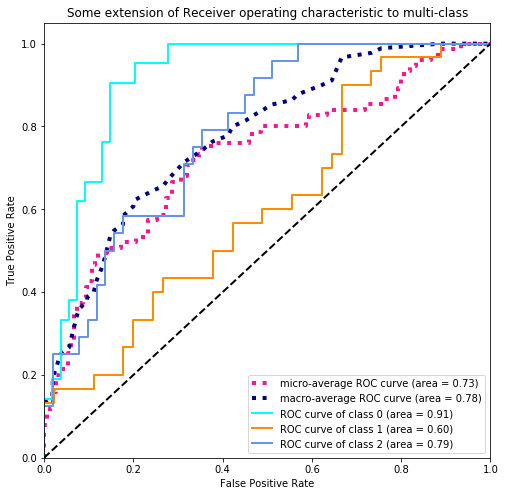

In [79]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()